# SINDy for neural inference
## Examples in Lorenz Systems


### Introduction
In this notebook we incorporate the SINDy autoencoder framework [Champion et al]() with an interactive Lorenz System implemented with IPyWidgets.


### Model
We start with the general form of the Lorenz system (code built on [ipywidgets Lorenz example](https://github.com/jupyter-widgets/ipywidgets/blob/80921ac9f9a18c43b02918ce3913818c188ae34c/docs/source/examples/Lorenz%20Differential%20Equations.ipynb)).

$$
\begin{aligned}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{aligned}
$$

Our parameters of interest are: (\\(\sigma\\), \\(\beta\\), \\(\rho\\))

#### Imports

In [9]:
import sys
sys.path.append("../../src")
import os
import numpy as np
import pickle
import pandas as pd

from scipy import integrate

# Import our basic plotting libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation

# Import our jupyter widgets
from ipywidgets import interact, interactive, fixed
from IPython.display import clear_output, display, HTML

import pysindy as ps

from scipy.integrate import odeint
from sklearn.linear_model import Lasso

%matplotlib inline

### Setting up our example

In [10]:
def solve_lorenz(N=10, angle=0.0, max_time=4.0, sigma=10.0, beta=8./3, rho=28.0):

    def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
        """Compute the time-derivative of a Lorenz system."""
        x, y, z = x_y_z
        return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

    # Choose random starting points, uniformly distributed from -15 to 15
    np.random.seed(1)
    x0 = -15 + 30 * np.random.random((N, 3))

    # Solve for the trajectories
    t = np.linspace(0, max_time, int(250*max_time))
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0i, t)
                      for x0i in x0])
    
    return t, x_t

def plot_lorenz(N=10, angle=0.0, max_time=4.0, sigma=10.0, beta=8./3, rho=28.0):
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    ax.axis('off')

    t,x_t = solve_lorenz(N,angle,max_time,sigma,beta,rho)
    # prepare the axes limits
    ax.set_xlim((-25, 25))
    ax.set_ylim((-35, 35))
    ax.set_zlim((5, 55))
    
    # choose a different color for each trajectory
    colors = plt.cm.viridis(np.linspace(0, 1, N))

    for i in range(N):
        x, y, z = x_t[i,:,:].T
        lines = ax.plot(x, y, z, '-', c=colors[i])
        plt.setp(lines, linewidth=2)

    ax.view_init(30, angle)
    plt.show()
    
    return t,x_t

<a id='choose_coeffs'></a>
#### Choosing our ground-truth model

Now we're going to select the coefficients for our specific system

In [11]:
w = interactive(plot_lorenz, angle=(0.,360.), max_time=fixed(4.0), 
                N=fixed(10), sigma=(-2.0,50.0), rho=(0.0,50.0))
display(w)

interactive(children=(FloatSlider(value=0.0, description='angle', max=360.0), FloatSlider(value=10.0, descript…

Now that we have a specific dynamics set from our parameters *and* a trajectory from a simulated experiment, we can use SINDy to try to infer the parameters of our system.


In [17]:
sigma = w.children[1].value
beta = w.children[2].value
rho = w.children[3].value

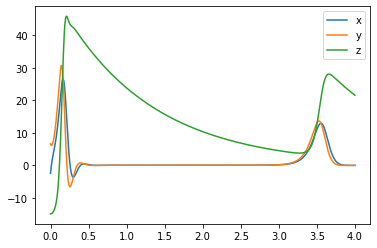

In [18]:
t = w.result[0]
x_t = w.result[1]
plt.figure()
plt.plot(t,x_t[0,:,0],label='x')
plt.plot(t,x_t[0,:,1],label='y')
plt.plot(t,x_t[0,:,2],label='z')
plt.legend()

# Enter SINDy-based inference

So we've got our function from above.

In [19]:
def lorenz(z, t):
    return [
        sigma * (z[1] - z[0]),
        z[0] * (rho - z[2]) - z[1],
        z[0] * z[1] - beta * z[2]
    ]

In [20]:
dt = .002

t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)

In [21]:
model = ps.SINDy()
model.fit(x_train, t=dt)
model.print()

x0' = -30.108 x0 + 30.108 x1
x1' = 17.589 x0 + -0.993 x1 + -1.000 x0 x2
x2' = -0.833 x2 + 1.000 x0 x1
